# Snapshot Ensembles experiments

### Построим ансамбль моделей для классификации MNIST, воспользовавшись концепцией 'Train 1, get M for free', описанной в статье https://arxiv.org/abs/1704.00109

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1


env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("..")

from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from ensemble_batch import MnistBatch
from ensemble_batch import draw_stats

## Загрузим данные MNIST

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

## Обучим модель на протяжении 2000 итераций с периодическим лернинг рейтом:

\begin{align}
\alpha(t) = \frac{\alpha_0}{2} \left( \cos \left( \frac{\pi mod(t-1, [T/M])}{[T/M]} \right) + 1 \right) \in [\alpha_0, 0]
\end{align}

## И сохраним $m$ промежуточных моделей на диск

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
loss_history = []
train_stats = []
train_loss_history = []

In [5]:
alpha = 0.01
period = 400
n_iterations = 2001

In [6]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess,  alpha, period, n_iterations, train_stats, train_loss_history))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats, loss_history))

In [7]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)
    if i % 501 == 0:
        print(i, 'current stat', stats[-10:])

  0%|                                                                                         | 0/2001 [00:00<?, ?it/s]

0 current stat [0.079999998]


 20%|███████████████▊                                                               | 400/2001 [02:01<10:22,  2.57it/s]

hey


 25%|███████████████████▊                                                           | 501/2001 [02:47<10:57,  2.28it/s]

501 current stat [0.93000001, 0.87, 0.88, 0.88, 0.88, 0.88999999, 0.92000002, 0.88999999, 0.92000002, 0.86000001]


 40%|███████████████████████████████▌                                               | 800/2001 [05:27<12:04,  1.66it/s]

hey


 50%|███████████████████████████████████████                                       | 1002/2001 [07:49<12:41,  1.31it/s]

1002 current stat [0.93000001, 0.95999998, 0.91000003, 0.93000001, 0.88, 0.94999999, 0.94, 0.91000003, 0.95999998, 0.94999999]


 60%|██████████████████████████████████████████████▊                               | 1200/2001 [10:29<10:30,  1.27it/s]

hey


 75%|██████████████████████████████████████████████████████████▌                   | 1503/2001 [15:24<07:58,  1.04it/s]

1503 current stat [0.95999998, 0.89999998, 0.92000002, 0.93000001, 0.95999998, 0.94, 0.94, 0.95999998, 0.88999999, 0.93000001]


 80%|██████████████████████████████████████████████████████████████▎               | 1600/2001 [17:05<06:50,  1.02s/it]

hey


100%|█████████████████████████████████████████████████████████████████████████████▉| 2000/2001 [25:08<00:01,  1.32s/it]

hey


100%|██████████████████████████████████████████████████████████████████████████████| 2001/2001 [25:28<00:00,  6.96s/it]


## Loss на валидации с 200-ой итерации:

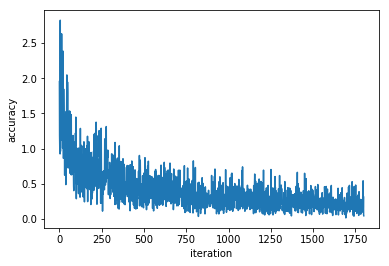

In [46]:
draw_stats(loss_history[200:], '')

## Для получения результатов ансамбля $m$ моделей, загрузим сохраненные модели и усредним выходы $softmax$ слоев каждой модели

In [18]:
config = {}
config['period'] = period
config['n_iterations'] = n_iterations


In [19]:
ensemble_stats = []
ensemble_loss_history = []

# pipeline for ensemble test
ppl_ens_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats_ensemble(config, ensemble_stats, ensemble_loss_history))

In [20]:
for i in tqdm(range(250)):
    ppl_ens_test.next_batch(100, n_epochs=None)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

i do hardcoding of n_iterations and period
currently loading trained+400/model-400.meta
INFO:tensorflow:Restoring parameters from trained+400/model-400
currently loading trained+800/model-800.meta
INFO:tensorflow:Restoring parameters from trained+800/model-800
currently loading trained+1200/model-1200.meta
INFO:tensorflow:Restoring parameters from trained+1200/model-1200
currently loading trained+1600/model-1600.meta
INFO:tensorflow:Restoring parameters from trained+1600/model-1600
currently loading trained+2000/model-2000.meta
INFO:tensorflow:Restoring parameters from trained+2000/model-2000


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:57<00:00,  5.98it/s]


In [26]:
В итоге лосс ансамбля моделей (после красной черты) действительно 

0.93611997

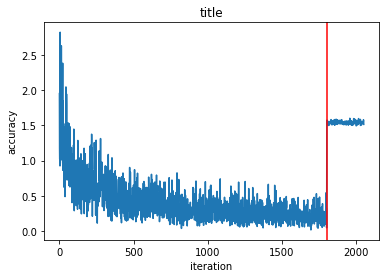

In [29]:
plt.title('title')
plt.plot(loss_history[200:] + ensemble_loss_history)
plt.axvline(x=1801, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

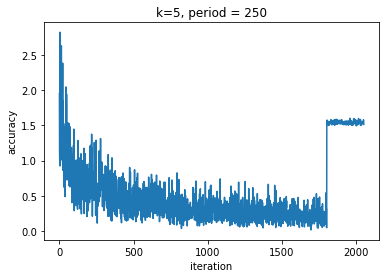

In [22]:
draw_stats(loss_history[200:] + ensemble_loss_history, 'k=5, period = 400')

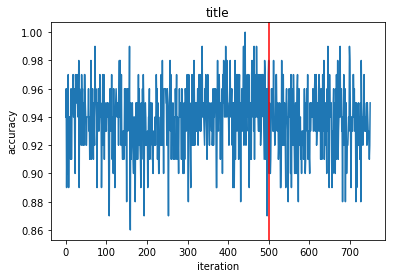

In [37]:
plt.title('title')
plt.plot(stats[1500:] + ensemble_stats)
plt.axvline(x=500, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [9]:
ensemble_loss_history[-2:]

NameError: name 'ensemble_loss_history' is not defined

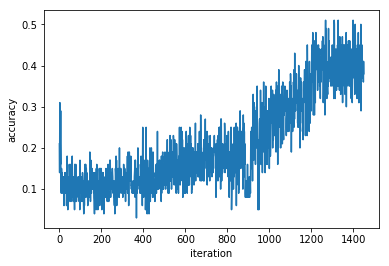

In [20]:
draw_stats(stats[800:] + ensemble_stats, '')

In [19]:
np.mean(ensemble_stats)

0.39635998

In [23]:
np.mean(stats[1400:])

0.22064891

In [29]:
stats[-2]

0.95999998